In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import sqrt
import pandas as pd
import scipy.constants as const
from scipy.optimize import curve_fit                        # Funktionsfit:     popt, pcov = curve_fit(func, xdata, ydata) 
from uncertainties import ufloat                            # Fehler:           fehlerwert =  ulfaot(x, err)
from uncertainties import unumpy as unp 
from uncertainties.unumpy import uarray                     # Array von Fehler: fehlerarray =  uarray(array, errarray)
from uncertainties.unumpy import (nominal_values as noms,   # Wert:             noms(fehlerwert) = x
                                  std_devs as stds)         # Abweichung:       stds(fehlerarray) = errarray
import os

Kontrast berechnen

In [3]:
md = pd.read_csv('tables/kontrast.csv')
md = md.to_numpy()
winkel = md[:,0]
U_max = md[:,1]
U_min = md[:,2]

K = (U_max - U_min) / (U_max + U_min)
K = np.round(K,3)
mdK = np.c_[md,K]
hea = list(['Winkel in °', 'U_{max}', 'U_{min}', 'Kontrast'])
pandas_mdK = pd.DataFrame(mdK, columns=['Winkel', 'Umax', 'Umin', 'Kontrast'])

Parameter:  [0.08778599 0.79556007] 
Fehler:  [0.03828754 0.00853422]
1.1519173063162575
Maximum liegt bei K = 0.7955445415407814 bei einem Winkel von 47.69387755102041


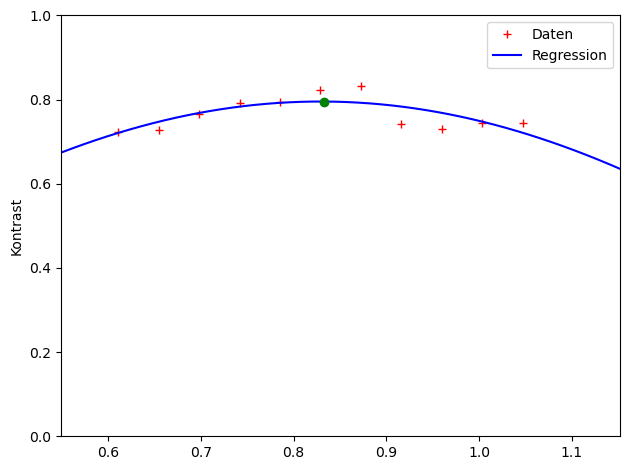

In [4]:
md = pd.read_csv('tables/kontrast.csv')
md = md.to_numpy()

def fit(winkel,delta, A):
    return A * np.abs(np.sin(2 * winkel - delta))
winkel = md[:,0]
winkel = winkel * np.pi / 180
params, cov = curve_fit(fit, winkel, K)
print('Parameter: ', params, '\nFehler: ', np.sqrt(np.diag(cov)))
x = np.linspace(winkel[0] * 0.9, winkel[-1] *1.1)

print(winkel[-1] *1.1)
plt.plot(winkel, K, 'r+', label="Daten")
plt.scatter(x[fit(x, *params).argmax()], fit(x, *params).max(), c='g', zorder=3)
plt.plot(x, fit(x, *params), 'b', label="Regression")
plt.ylabel('Kontrast')
plt.xlim(x[0], x[-1])
plt.ylim(0, 1)
plt.tight_layout()
plt.legend(loc="best")

print('Maximum liegt bei K = ' + str(fit(x, *params).max()) + ' bei einem Winkel von ' + str(x[fit(x, *params).argmax()] * 180 / np.pi))

Bereche $n_{Luft}$

Parameter:  [-0.68453446 43.03963481] 
Fehler:  [0.17064271 0.31223316]
n = 1.0001338+/-0.0000011


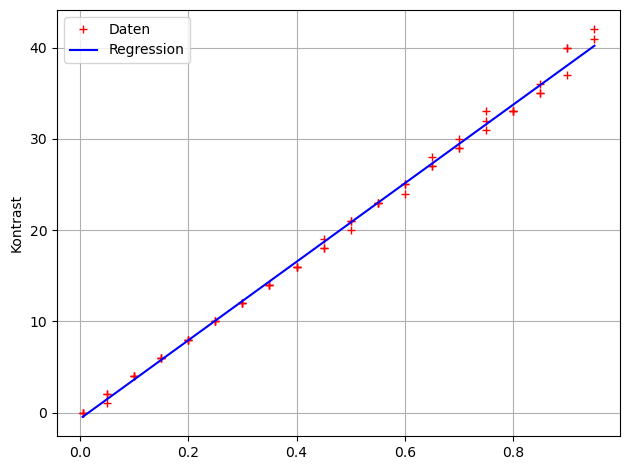

In [6]:
md = pd.read_csv('tables/n_luft.csv')
md = md.to_numpy()
T = const.convert_temperature(21.5, 'Celsius', 'Kelvin')

def func(p, a, m):
    return a + p * m

def nn(M):
    return  M *632.8 * 10**(-9) / L
p = md[:,0]
maxima1 = md[:,1]; maxima2  = md[:,2]; maxima3 = md[:,3]
p_c = np.concatenate((p[:-1],p,p),axis=None)
max_c = np.concatenate((maxima1[:-1],maxima2,maxima3),axis=None)
params, cov = curve_fit(func, p_c, max_c)
print('Parameter: ', params, '\nFehler: ', np.sqrt(np.diag(cov)))
plt.plot(p_c, max_c, 'r+', label="Daten")
plt.plot(p, func(p, *params), 'b', label="Regression")
plt.ylabel('Kontrast')
plt.tight_layout()
plt.grid(':')
plt.legend(loc="best")

a = ufloat(params[0], np.sqrt(np.diag(cov))[0])
m = ufloat(params[1], np.sqrt(np.diag(cov))[1])
M = func(0.95, a,m)

print('n = ' + str( M * 332.8 * 10**-8 + 1))

Parameter:  [0.07825291] 
Fehler:  [0.00033909]


/tmp/ipykernel_9735/1471612444.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  md = md.to_latex(index = False, column_format= "c c c c", decimal=',', header=hea, label='tab:luft', caption="Messwerte zum Brechungsindex von Luft")


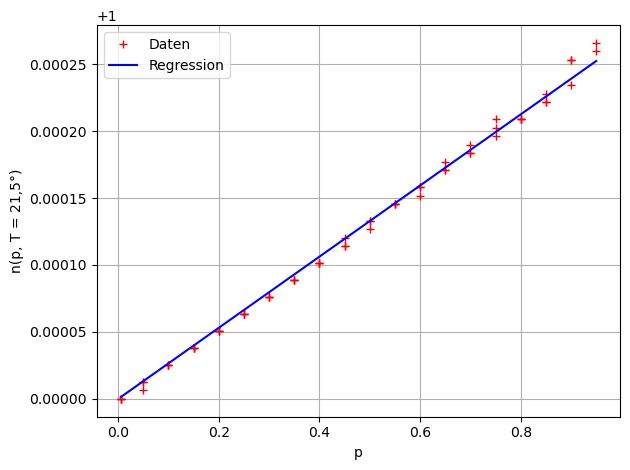

1.005285+/-0.000023


In [23]:
md = pd.read_csv('tables/n_luft.csv')
hea = list(['Maxima', 'Versuch 1', 'Versuch 2', 'Versuch 3'])
md = md.to_latex(index = False, column_format= "c c c c", decimal=',', header=hea, label='tab:luft', caption="Messwerte zum Brechungsindex von Luft")
with open('build/n_luft.txt', 'w') as f:
    f.write(md)

md = pd.read_csv('tables/n_luft.csv')
md = md.to_numpy()
T = const.convert_temperature(21.5, 'Celsius', 'Kelvin')

def func1(p, m):     # Lorentz-Lorenz
    return p * m / T + 1

L = 0.1 # in meter

def n_mit_druck(M): 
    return M * 632.8 * 10**(-9) / L + 1


p = md[:,0]
maxima1 = md[:,1]; maxima2  = md[:,2]; maxima3 = md[:,3]
p_c = np.concatenate((p[:-1],p,p),axis=None)
max_c = np.concatenate((maxima1[:-1],maxima2,maxima3),axis=None)


n_mit_druck_gemessen = n_mit_druck(max_c)
params, cov = curve_fit(func1, p_c, n_mit_druck_gemessen)
print('Parameter: ', params, '\nFehler: ', np.sqrt(np.diag(cov)))

plt.plot(p_c, n_mit_druck_gemessen, 'r+', label="Daten")
plt.plot(p, func1(p, *params), 'b', label="Regression")
plt.ylabel('n(p, T = 21,5°)')
plt.xlabel('p')
plt.tight_layout()
plt.grid(':')
plt.legend(loc="best")
plt.show()

def func2(p, T2, m):
    return p * m / T2 + 1

m = ufloat(params, np.sqrt(np.diag(cov)))

print(func2(1.013, 15, m))